# VGG-16 Model Trained from Scratch

This file is used to train a VGG-16 model from scratch on the adapted cars dataset (49 classes, images cropped around the bounding boxes, and 50% more training data).

In [1]:
# importing libaries
import matplotlib.pylab as plt
import numpy as np
import tensorflow as tf
import pandas as pd
import cv2
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Input
from keras.applications.vgg16 import VGG16

In [4]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [3]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [ ]:
%cd /content/gdrive/MyDrive/Kaggle/data
!unzip \*.zip && rm *.zip

In [15]:
gen_params = {"rescale":1.0/255,
              "featurewise_center":False,
              "samplewise_center":False,
              "featurewise_std_normalization":False,
              "samplewise_std_normalization":False,
              "zca_whitening":False,
              "rotation_range":20,
              "width_shift_range":0.1,
              "height_shift_range":0.1,
              "shear_range":0.2,
              "zoom_range":0.1,
              "horizontal_flip":True,
              "fill_mode":'constant',
              "cval": 0,
              "validation_split":0.2}

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(**gen_params)
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1/255.0)


## Data generator for training images
train_generator = train_datagen.flow_from_directory('/content/gdrive/MyDrive/Kaggle/data/car_data/train',
                                                    class_mode='categorical', batch_size = 32,
                                                    target_size=(224,224),color_mode='rgb',shuffle = True,subset='training')

val_generator = train_datagen.flow_from_directory('/content/gdrive/MyDrive/Kaggle/data/car_data/train',
                                                    class_mode='categorical', batch_size = 32, 
                                                    target_size=(224,224),color_mode='rgb',shuffle = True,subset='validation')

test_generator = test_datagen.flow_from_directory('/content/gdrive/MyDrive/Kaggle/data/car_data/test',
                                                    class_mode='categorical', batch_size = 32,
                                                    target_size=(224,224),color_mode='rgb',shuffle = True)

Found 9743 images belonging to 49 classes.
Found 2416 images belonging to 49 classes.
Found 4026 images belonging to 49 classes.


In [22]:
def build_vgg16_model(img_height=224,img_width=224,num_classes=49):

    input = Input(shape =(224,224,3))
    
    # 1st Conv Block
    x = Conv2D (filters =64, kernel_size =3, padding ='same', activation='relu')(input)
    x = Conv2D (filters =64, kernel_size =3, padding ='same', activation='relu')(x)
    x = MaxPool2D(pool_size =2, strides =2, padding ='same')(x)

    # 2nd Conv Block
    x = Conv2D (filters =128, kernel_size =3, padding ='same', activation='relu')(x)
    x = Conv2D (filters =128, kernel_size =3, padding ='same', activation='relu')(x)
    x = MaxPool2D(pool_size =2, strides =2, padding ='same')(x)

    # 3rd Conv block  
    x = Conv2D (filters =256, kernel_size =3, padding ='same', activation='relu')(x) 
    x = Conv2D (filters =256, kernel_size =3, padding ='same', activation='relu')(x) 
    x = Conv2D (filters =256, kernel_size =3, padding ='same', activation='relu')(x) 
    x = MaxPool2D(pool_size =2, strides =2, padding ='same')(x)

    # 4th Conv block
    x = Conv2D (filters =512, kernel_size =3, padding ='same', activation='relu')(x)
    x = Conv2D (filters =512, kernel_size =3, padding ='same', activation='relu')(x)
    x = Conv2D (filters =512, kernel_size =3, padding ='same', activation='relu')(x)
    x = MaxPool2D(pool_size =2, strides =2, padding ='same')(x)

    # 5th Conv block
    x = Conv2D (filters =512, kernel_size =3, padding ='same', activation='relu')(x)
    x = Conv2D (filters =512, kernel_size =3, padding ='same', activation='relu')(x)
    x = Conv2D (filters =512, kernel_size =3, padding ='same', activation='relu')(x)
    x = MaxPool2D(pool_size =2, strides =2, padding ='same')(x)

    # Fully connected layers  
    x = Flatten()(x) 
    x = Dense(units = 4096, activation ='relu')(x) 
    x = Dense(units = 4096, activation ='relu')(x) 
    out = Dense(units = 49, activation ='softmax')(x)

    #compile and return
    model = tf.keras.Model(inputs = input, outputs =out)  
    model.compile(optimizer=tf.keras.optimizers.Adam(lr = 1e-4),loss='categorical_crossentropy',metrics=['accuracy'])
    
    return model

In [23]:
model = build_vgg16_model()
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 224, 224, 64)      1792      
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 224, 224, 64)      36928     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 112, 112, 128)     73856     
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 112, 112, 128)     147584    
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 56, 56, 128)       0   

In [24]:
model_name = "vgg16_cars_49_classes_from_scratch.h5"
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience = 20)

monitor = tf.keras.callbacks.ModelCheckpoint(model_name, monitor='val_loss',\
                                             verbose=0,save_best_only=True,\
                                             save_weights_only=True,\
                                             mode='min')
# Learning rate schedule
def scheduler(epoch, lr):
    if epoch%4 == 0 and epoch!= 0:
        lr = lr/2
    return lr

lr_schedule = tf.keras.callbacks.LearningRateScheduler(scheduler,verbose = 0)

In [25]:
batch = 128
num_epochs = 100

history = model.fit(train_generator,
                    validation_data = val_generator,
                    epochs=num_epochs,
                    verbose=1,
                    batch_size=batch,
                    callbacks=[early_stop,monitor,lr_schedule])

Epoch 1/100
305/305 [==============================] - 306s 1000ms/step - loss: 3.5314 - accuracy: 0.1002 - val_loss: 3.4478 - val_accuracy: 0.1118
Epoch 2/100
305/305 [==============================] - 300s 981ms/step - loss: 3.4468 - accuracy: 0.1100 - val_loss: 3.4364 - val_accuracy: 0.1118
Epoch 3/100
305/305 [==============================] - 296s 970ms/step - loss: 3.4322 - accuracy: 0.1094 - val_loss: 3.4344 - val_accuracy: 0.1118
Epoch 4/100
305/305 [==============================] - 293s 959ms/step - loss: 3.4572 - accuracy: 0.1084 - val_loss: 3.4357 - val_accuracy: 0.1118
Epoch 5/100
305/305 [==============================] - 288s 945ms/step - loss: 3.4347 - accuracy: 0.1117 - val_loss: 3.4327 - val_accuracy: 0.1118
Epoch 6/100
305/305 [==============================] - 290s 951ms/step - loss: 3.4389 - accuracy: 0.1120 - val_loss: 3.3836 - val_accuracy: 0.1163
Epoch 7/100
305/305 [==============================] - 288s 942ms/step - loss: 3.4023 - accuracy: 0.1116 - val_loss: 

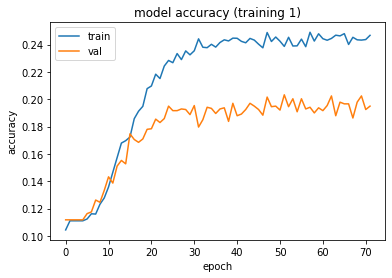

In [26]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy (training 1)')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [27]:
model.load_weights(model_name)
metrics = model.evaluate(test_generator)

126/126 [==============================] - 48s 379ms/step - loss: 2.8902 - accuracy: 0.2064


In [28]:
max(history.history['val_accuracy'])

0.20322847366333008

In [29]:
max(history.history['accuracy'])

0.24899928271770477